# Predict Future Sales

## Imports

In [1]:
import pandas as pd
pd.set_option('float_format', '{0:.2f}'.format)

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Import data

In [2]:
train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")
categories = pd.read_csv("data/item_categories.csv")
shops = pd.read_csv("data/shops.csv")
test = pd.read_csv("data/test.csv")

In [3]:
df_train = train.copy()

## Data Cleaning

### Cleaning the training set

In [4]:
df_train.rename(columns={'item_cnt_day' : 'item_volume'}, inplace=True)

In [5]:
# Replace negative price
df_train["item_price"] = np.where(df_train.item_price < 0,
                            df_train[(df_train.date_block_num==4) & (df_train.shop_id==32) & (df_train.item_id==2973)]["item_price"].median(),
                            df_train.item_price)

#### Remove outliers

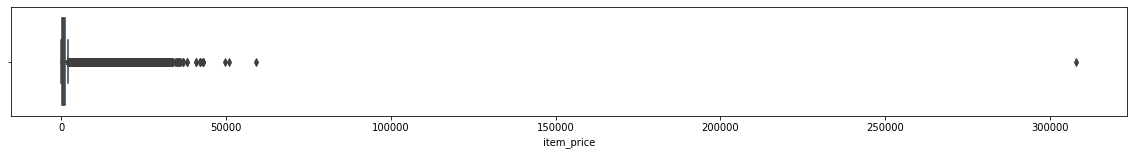

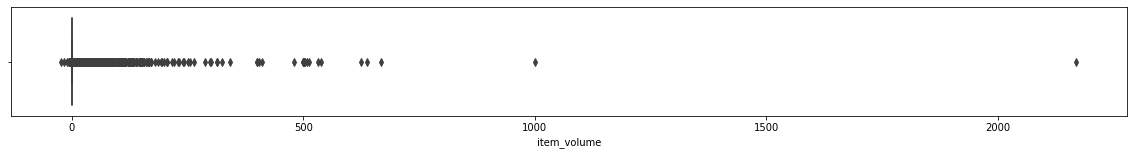

In [6]:
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_price)
plt.show()
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_volume)
plt.show()

In [7]:
# Remove outliers
df_train = df_train[df_train.item_price < 100000]
df_train = df_train[df_train.item_volume < 100]

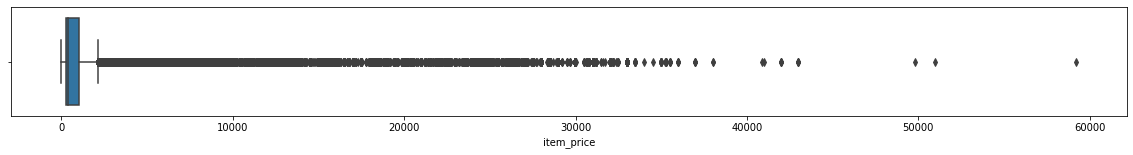

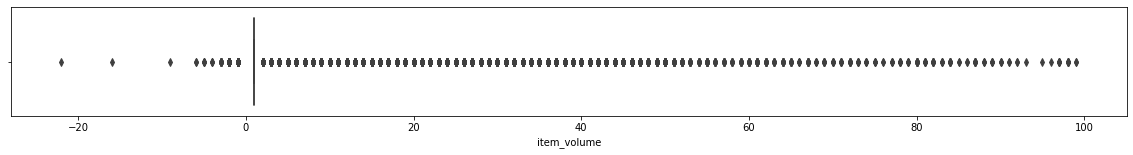

In [8]:
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_price)
plt.show()
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_volume)
plt.show()

### Group by Month, Shop & Item

In [9]:
df_train["date"] = pd.to_datetime(df_train["date"], format='%d.%m.%Y')
df_train["month"] = df_train["date"].dt.month
df_train["year"] = df_train["date"].dt.year
#df_train["month_year"] = df_train["date"].dt.strftime('%Y-%m')
#df_train["month_year"] = pd.to_datetime(df_train["month_year"])

In [10]:
gp = df_train.groupby(["date_block_num", "year", "month", "shop_id", "item_id"]).agg({'item_volume' : 'sum', 'item_price' : 'mean'}).reset_index()

In [152]:
gp

,date_block_num,year,month,shop_id,item_id,item_volume,item_price
0,0,2013,1,0,32,6.00,221.00
1,0,2013,1,0,33,3.00,347.00
2,0,2013,1,0,35,1.00,247.00
3,0,2013,1,0,43,1.00,221.00
4,0,2013,1,0,51,2.00,128.50
...,...,...,...,...,...,...,...
1609112,33,2015,10,59,22087,6.00,119.00
1609113,33,2015,10,59,22088,2.00,119.00
1609114,33,2015,10,59,22091,1.00,179.00
1609115,33,2015,10,59,22100,1.00,629.00


In [151]:
# VOLUME CAN BE 0 (returns are negative)
df_train[(df_train.item_id==5643) & (df_train.date_block_num==0) & (df_train.shop_id==2)]

,date,date_block_num,shop_id,item_id,item_price,item_volume,month,year
32745,2013-01-02,0,2,5643,2385.21,-1.00,1,2013
32746,2013-01-06,0,2,5643,2390.00,1.00,1,2013


### Prepare test set and concatenate with training set

In [12]:
df_test = test.copy()

In [13]:
df_test["date_block_num"] = 34
df_test["year"] = 2015
df_test["month"] = 11
df_test["item_volume"] = 0
df_test["item_price"] = 0

In [14]:
df_test = df_test[["date_block_num", "year", "month", "shop_id", "item_id", "item_volume", "item_price"]]

In [15]:
df = pd.concat([gp, df_test], ignore_index=True)

In [16]:
df["revenue"] = df["item_volume"] * df["item_price"]

In [17]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823317 entries, 0 to 1823316
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int16  
 1   year            int16  
 2   month           int16  
 3   shop_id         int16  
 4   item_id         int16  
 5   item_volume     float32
 6   item_price      float32
 7   revenue         float32
dtypes: float32(3), int16(5)
memory usage: 38.3 MB


### Prepare Shops & Categories

In [19]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[["shop_id", "city_code"]]

In [20]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['cat'] = categories['split'].map(lambda x: x[0].strip())
categories['cat_code'] = LabelEncoder().fit_transform(categories['cat'])
# if subcategory is nan then category
categories['subcat'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subcat_code'] = LabelEncoder().fit_transform(categories['subcat'])
categories = categories[["item_category_id", "cat_code", "subcat_code"]]

In [21]:
items.drop(columns=["item_name"], axis=1, inplace=True)

### Merge & process dates

In [22]:
full_data = pd.merge(df, items, on=["item_id"], how='left')
full_data = pd.merge(full_data, categories, on="item_category_id", how='left')
full_data = pd.merge(full_data, shops, on="shop_id", how='left')

In [155]:
df = full_data.copy()

In [156]:
df

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,subcat_code,city_code
0,0,2013,1,0,32,6.00,221.00,1326.00,40,11,4,0
1,0,2013,1,0,33,3.00,347.00,1041.00,37,11,1,0
2,0,2013,1,0,35,1.00,247.00,247.00,40,11,4,0
3,0,2013,1,0,43,1.00,221.00,221.00,40,11,4,0
4,0,2013,1,0,51,2.00,128.50,257.00,57,13,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1823312,34,2015,11,45,18454,0.00,0.00,0.00,55,13,2,21
1823313,34,2015,11,45,16188,0.00,0.00,0.00,64,14,42,21
1823314,34,2015,11,45,15757,0.00,0.00,0.00,55,13,2,21
1823315,34,2015,11,45,19648,0.00,0.00,0.00,40,11,4,21


### KPIs

In [157]:
def _add_kpi(df, index_columns, col_name, kpi, agg, lag=0):
    temp = df.groupby(index_columns).agg({ kpi : agg}).reset_index()
    temp["date_block_num"] = temp["date_block_num"] + lag
    if lag==0:
        lag_str = ""
    else:
        lag_str = "_" + str(lag)
    temp = temp.rename(columns={ kpi : (col_name + lag_str) })
    df = pd.merge(df, temp, how='left', on = index_columns)
    # Avoid 0 volume
    df[col_name + lag_str] = np.where(df[col_name + lag_str]==0, 1, df[col_name + lag_str])
    if lag!=0:
        df[col_name + lag_str + "_trend"] = \
        (df["item_volume"] - df[col_name + lag_str]) / df[col_name + lag_str]
    return df

In [158]:
def _add_lag_item(df, lag=0):
    temp = df[["date_block_num", "item_id", "shop_id", "item_volume"]]
    temp["date_block_num"] = temp["date_block_num"] + lag   
    temp = temp.rename(columns={ "item_volume" : ("item_volume_" + str(lag)) })
    df = pd.merge(df, temp, how='left', on = ["date_block_num", "shop_id", "item_id"])
    # Avoid 0 volume
    df["item_volume_" + str(lag)] = np.where(df["item_volume_" + str(lag)]==0, 1, df["item_volume_" + str(lag)])
    df["item_volume_" + str(lag) + "_trend"] = \
    (df["item_volume"] - df["item_volume_" + str(lag)]) / df["item_volume_" + str(lag)]
    return df 

#### Sum

In [159]:
# Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum")
# Sum of item_volume groupby month, shop
df = _add_kpi(df, ["date_block_num", "shop_id"], "sum_volume_month_shop", "item_volume", "sum")
# Sum of item_volume groupby month, shop, category
df = _add_kpi(df, ["date_block_num", "shop_id", "item_category_id"], "sum_volume_month_shop_category", "item_volume", "sum")

#### Mean

In [160]:
# Mean of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "mean_volume_month", "item_volume", "mean")
# Mean of item_volume groupby month, shop
df = _add_kpi(df, ["date_block_num", "shop_id"], "mean_volume_month_shop", "item_volume", "mean")
# Mean of item_volume groupby month, shop, category
df = _add_kpi(df, ["date_block_num", "shop_id", "item_category_id"], "mean_volume_month_shop_category", "item_volume", "mean")

In [161]:
df

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,subcat_code,city_code,sum_volume_month,sum_volume_month_shop,sum_volume_month_shop_category,mean_volume_month,mean_volume_month_shop,mean_volume_month_shop_category
0,0,2013,1,0,32,6.00,221.00,1326.00,40,11,4,0,131479.00,5578.00,1838.00,2.08,2.34,2.21
1,0,2013,1,0,33,3.00,347.00,1041.00,37,11,1,0,131479.00,5578.00,302.00,2.08,2.34,1.44
2,0,2013,1,0,35,1.00,247.00,247.00,40,11,4,0,131479.00,5578.00,1838.00,2.08,2.34,2.21
3,0,2013,1,0,43,1.00,221.00,221.00,40,11,4,0,131479.00,5578.00,1838.00,2.08,2.34,2.21
4,0,2013,1,0,51,2.00,128.50,257.00,57,13,8,0,131479.00,5578.00,60.00,2.08,2.34,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823312,34,2015,11,45,18454,0.00,0.00,0.00,55,13,2,21,1.00,1.00,1.00,1.00,1.00,1.00
1823313,34,2015,11,45,16188,0.00,0.00,0.00,64,14,42,21,1.00,1.00,1.00,1.00,1.00,1.00
1823314,34,2015,11,45,15757,0.00,0.00,0.00,55,13,2,21,1.00,1.00,1.00,1.00,1.00,1.00
1823315,34,2015,11,45,19648,0.00,0.00,0.00,40,11,4,21,1.00,1.00,1.00,1.00,1.00,1.00


#### Lags

In [162]:
# Lag 1 month Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 12)

In [163]:
# Lag 1 month Sum of item_volume
df = _add_lag_item(df, 1)
# Lag 12 month Sum of item_volume
df = _add_lag_item(df, 12)

/Users/taharaouz/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Model

In [164]:
df = df.fillna(0)

In [165]:
df[(df.item_volume==0) & (df.date_block_num!=34)]

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,...,mean_volume_month_shop,mean_volume_month_shop_category,sum_volume_month_1,sum_volume_month_1_trend,sum_volume_month_12,sum_volume_month_12_trend,item_volume_1,item_volume_1_trend,item_volume_12,item_volume_12_trend
4147,0,2013,1,2,5643,0.00,2387.60,0.00,2,1,...,1.57,2.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5609,0,2013,1,4,7218,0.00,1594.00,0.00,19,5,...,1.99,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6558,0,2013,1,6,3676,0.00,2199.00,0.00,23,5,...,1.98,2.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6566,0,2013,1,6,3778,0.00,899.00,0.00,58,13,...,1.98,1.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6753,0,2013,1,6,5753,0.00,3490.00,0.00,75,15,...,1.98,3.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604603,33,2015,10,52,18187,0.00,299.00,0.00,57,13,...,1.48,0.88,68797.00,-1.00,104688.00,-1.00,0.00,0.00,0.00,0.00
1605813,33,2015,10,56,1538,0.00,999.00,0.00,19,5,...,1.57,1.54,68797.00,-1.00,104688.00,-1.00,0.00,0.00,0.00,0.00
1605870,33,2015,10,56,3237,0.00,1998.00,0.00,20,5,...,1.57,2.15,68797.00,-1.00,104688.00,-1.00,2.00,-1.00,8.00,-1.00
1606531,33,2015,10,56,19858,0.00,249.00,0.00,40,11,...,1.57,1.36,68797.00,-1.00,104688.00,-1.00,1.00,-1.00,3.00,-1.00


In [166]:
X_train = df[df.date_block_num.isin(range(1,34))].drop(columns=["item_volume"])
y_train = df[df.date_block_num.isin(range(1,34))]["item_volume"]

#X_val = df[df.date_block_num==33].drop(columns=["item_volume"])
#y_val = df[df.date_block_num==33][["item_volume"]]

X_test = df[df.date_block_num==34].drop(columns=["item_volume"])

In [167]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [177]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=3, max_depth=5)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=3)

In [178]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

In [180]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores)

array([0.64576238, 0.95951433, 0.7269344 , 1.56181364, 2.48197766])

In [173]:
y_test = model.predict(X_test)

In [176]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('submission.csv', index=False)